# **BirdCLEF 2025 Data Preprocessing Notebook**

In [1]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import os
import numpy as np
from datetime import datetime
import pytz
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold

from joblib import Parallel, delayed

from importlib import reload

from module import config_lib, utils_lib

In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.PROCESSED_DIR = ""
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'


        # ===== Audio Settings =====
        self.FS = 32000
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 16
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.N_JOBS_DURATION = 47
        
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
        self.n_fold = 5
        self.num_rare_samples = 10 # これ以下のサンプル数のspeciesはrare speciesとして扱う
        self.is_crop_aug = False
        self.num_prune_samples = 1000 # サンプル数をこれ以下にprune
        
        self.crop_strategy = 'head'  # random or center

In [3]:
config = DatasetConfig(kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(config.seed)

In [5]:
print(f"Debug mode: {'ON' if config.debug else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.RAW_DIR}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.RAW_DIR}/train.csv')

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...


In [6]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df.copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.RAW_DIR + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
working_df["crop_strategy"] = "center"
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

# 音源の長さをロードして追加．
duration_df = pd.read_csv("../data/processed/train_duration.csv")
working_df = working_df.merge(duration_df, on="filename", how="left")

missing = working_df["duration_sec"].isna().sum()
print(f"✅ Added 'duration_sec'. Missing values: {missing}")

Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64
✅ Added 'duration_sec'. Missing values: 0


In [7]:
# # 全音源の長さを計算
# def get_duration(filepath, sr):
#     try:
#         audio, _ = librosa.load(filepath, sr=sr)
#         return len(audio) / sr
#     except Exception as e:
#         print(f"[ERROR] Could not load {filepath}: {e}")
#         return np.nan

# print("🔄 Calculating durations with parallel processing...")

# # tqdm 対応
# filepaths = working_df['filepath'].tolist()
# durations = Parallel(n_jobs=config.N_JOBS_DURATION)(
#     delayed(get_duration)(fp, config.FS) for fp in tqdm(filepaths)
# )

# working_df['duration_sec'] = durations
# print("✅ Added 'duration_sec' column to working_df")

In [8]:
working_df["valid_start_sec"] = 0
working_df["valid_end_sec"] = working_df["duration_sec"]

In [9]:
# 手動で人の声除去

# 4. 特定のファイルの valid_start_sec を変更
# 特定のファイル（最初にスペイン語が含まれる）
spanish_intro_filenames = [
    '50186/CSA28885.ogg',
    '52884/CSA14875.ogg'
]
# valid_start_sec を 4.0 に変更
working_df.loc[
    working_df['filename'].isin(spanish_intro_filenames),
    'valid_start_sec'
] = 4.0


# 途中で人の声のみになるので除去
voice_only_ranges = {
    '476537/CSA35459.ogg': 134,  # 2分14秒 = 134秒
    '476537/CSA35461.ogg': 259,  # 4分19秒 = 259秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Eliana Barona- Cortés　の音源．話している部分．いらない部分
# 24292/CSA34649.ogg 2min8以降
# 24292/CSA34651.ogg 1min33以降
# 50186/CSA34622.ogg 21s以降
# 50186/CSA34678.ogg 43s以降
voice_only_ranges = {
    '24292/CSA34649.ogg': 128,   # 2分8秒 = 128秒
    '24292/CSA34651.ogg': 93,    # 1分33秒 = 93秒
    '50186/CSA34622.ogg': 21,    # 21秒
    '50186/CSA34678.ogg': 43,    # 43秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec

# Alexandra Butrago-Cardona の音源チェック
# 話している部分．いらない部分
# 24292/CSA35021.ogg 36s以降
# 52884/CSA34947.ogg 13s以降
voice_only_ranges = {
    '24292/CSA35021.ogg': 36,    # 36秒
    '52884/CSA34947.ogg': 13,     # 13秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Fabio A. Sarria-S の音声は 0〜7秒 だけ使用可能に設定．後半はただの説明なので
fabio_filenames = train_df.loc[
    train_df['author'] == "Fabio A. Sarria-S", 'filename'
].tolist()
# 
working_df.loc[
    working_df['filename'].isin(fabio_filenames), 'valid_end_sec'
] = 7.0

#  Fabioの解説で，必ずしも7secではないもの
fabio_override = {
    "48124/CSA36346.ogg": 24.0,
    "52884/CSA36344.ogg": 55.0,
    "52884/CSA36342.ogg": 14.0,  # ← 追加分
}

for fname, end_sec in fabio_override.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# crop戦略
working_df["crop_strategy"] = config.crop_strategy

In [10]:
# safezoneの0-1000のデータを更新．

# safe_zoneを準備（すでに"checked"のみ、重複除去済み）
safe_zone = pd.read_csv("../data/processed/safe_zones/safezone_1000_0501.csv")
safe_zone = safe_zone[safe_zone["check"] == "checked"]
safe_zone = safe_zone.drop_duplicates(subset=["filename"])

# start, endをfloatに変換
safe_zone["start"] = pd.to_numeric(safe_zone["start"], errors="coerce")
safe_zone["end"] = pd.to_numeric(safe_zone["end"], errors="coerce")

# safe_zoneから必要なカラムだけ持ってくる
safe_zone_update = safe_zone[["filename", "start", "end"]]

# working_dfも用意されている想定

# working_dfにsafe_zoneのstart, endをマージする
working_df = working_df.merge(safe_zone_update, on="filename", how="left")

# start, endが存在するものについて、valid_start_sec, valid_end_secを書き換え
working_df["valid_start_sec"] = working_df["start"].combine_first(working_df["valid_start_sec"])
working_df["valid_end_sec"] = working_df["end"].combine_first(working_df["valid_end_sec"])

# 使い終わったstart, endカラムを消す（必要なら）
working_df = working_df.drop(columns=["start", "end"])

In [11]:
# safezoneの1000-2000, 2000-3000のデータを更新．

# 追加入力用のsafe_zoneファイルのパス
safezone_files = [
    "../data/processed/safe_zones/safe_zone1000_2000_sorted_0517.csv",
    "../data/processed/safe_zones/safe_zone2000_3000_sorted_0517.csv"
]

# 各ファイルを順に処理
for file in safezone_files:
    safezone = pd.read_csv(file)
    
    # 不要なカラムがあれば削除
    safezone = safezone.loc[:, ~safezone.columns.str.contains('^Unnamed')]
    
    # カラム名が違う場合に対応（"check"に揃える）
    if "is_checked" in safezone.columns:
        safezone = safezone.rename(columns={"is_checked": "check"})
    
    # "checked" のみを抽出し、重複を削除
    safezone = safezone[safezone["check"] == "checked"]
    safezone = safezone.drop_duplicates(subset=["filename"])
    
    # 数値型への変換
    safezone["start"] = pd.to_numeric(safezone["start"], errors="coerce")
    safezone["end"] = pd.to_numeric(safezone["end"], errors="coerce")
    
    # 必要なカラムだけ残す
    safezone_update = safezone[["filename", "start", "end"]]

    # マージ
    working_df = working_df.merge(safezone_update, on="filename", how="left")

    # valid_start_sec, valid_end_sec を上書き
    working_df["valid_start_sec"] = working_df["start"].combine_first(working_df["valid_start_sec"])
    working_df["valid_end_sec"] = working_df["end"].combine_first(working_df["valid_end_sec"])

    # 使い終わったカラムを削除
    working_df = working_df.drop(columns=["start", "end"])

In [12]:
working_df["is_valid_audio"] = True

# ラベルごとに処理
for label, group in working_df.groupby('primary_label'):
    if len(group) > config.num_prune_samples:
        # ランダムに500件を残す（残りをis_valid_audio=Falseに）
        keep_indices = group.sample(n=config.num_prune_samples, random_state=config.seed).index
        drop_indices = group.index.difference(keep_indices)
        working_df.loc[drop_indices, 'is_valid_audio'] = False
        print(label)

print(f"✅ Marked {(~working_df['is_valid_audio']).sum()} samples as invalid (over {config.num_prune_samples} per label)")


# # # === 2. 除去対象ファイルを False に上書き ===
# fabio_remove_filenames = [
#     '1139490/CSA36385.ogg',
#     '1462737/CSA36369.ogg',
#     '1462737/CSA36380.ogg',
#     '1462737/CSA36381.ogg',
#     '1462737/CSA36386.ogg',
#     '1462737/CSA36391.ogg',
#     '1462737/CSA36395.ogg',
#     '963335/CSA36374.ogg',
#     '963335/CSA36375.ogg',
# ]
# working_df.loc[working_df["filename"].isin(fabio_remove_filenames), "is_valid_audio"] = False

# ノイズ除去するファイルを指定
working_df["apply_denoise"] = False

# fabio_denoise_filenames = [
#     '1462711/CSA36371.ogg',
#     '1462711/CSA36379.ogg',
#     '963335/CSA36372.ogg',
#     '963335/CSA36377.ogg',
# ]

# working_df.loc[working_df["filename"].isin(fabio_denoise_filenames), "apply_denoise"] = True

✅ Marked 0 samples as invalid (over 1000 per label)


In [13]:
# augmentationのための処理．各音源でどれくらい増やすのかを事前に決定

# 初期化
working_df['n_augment'] = 0
working_df['multi_crop'] = False

target_samples = int(config.TARGET_DURATION * config.FS)

# valid_end_sec が None なら duration_sec に補完
working_df['valid_end_sec'] = working_df.apply(
    lambda row: row['duration_sec'] if pd.isna(row['valid_end_sec']) else row['valid_end_sec'],
    axis=1
)

# valid_start_sec が None なら 0 に補完（念のため）
working_df['valid_start_sec'] = working_df['valid_start_sec'].fillna(0)

# rareなラベルを抽出
label_counts = working_df['primary_label'].value_counts().rename_axis("label").reset_index(name="sample_count")
rare_labels = label_counts[label_counts['sample_count'] < config.num_rare_samples]['label'].tolist()

# ✅ rare種ごとに crop 数を割り当てる
for rare_label in rare_labels:
    base_rows = working_df[working_df['primary_label'] == rare_label]
    n_exist = len(base_rows)
    n_needed = config.num_rare_samples - n_exist
    n_aug_per_sample = math.ceil(n_needed / n_exist)

    for idx, row in base_rows.iterrows():
        usable_duration_sec = row['valid_end_sec'] - row['valid_start_sec']
        usable_samples = int(usable_duration_sec * config.FS)

        # 少なくとも2倍にする
        max_possible = usable_samples // target_samples
        n_actual = min(n_aug_per_sample, max_possible)

        if n_actual > 0:
            working_df.at[idx, 'multi_crop'] = True
            working_df.at[idx, 'n_augment'] = n_actual
            
            
if not config.is_crop_aug:
    working_df['n_augment'] = 0
    working_df['multi_crop'] = False

# num_augmented
print(f"Total number of augmentations: {working_df['n_augment'].sum()}")

Total number of augmentations: 0


In [14]:
# crop_strategyに基づいて音声データを切り出す
# 現状centerしか使ってないのであまり意味がないコード．
def crop_audio(audio_data: np.ndarray, target_samples: int, strategy='center'):
    total_samples = len(audio_data)

    if total_samples < target_samples:
        n_copy = math.ceil(target_samples / total_samples)
        audio_data = np.concatenate([audio_data] * n_copy)
        total_samples = len(audio_data)

    if strategy == 'head':
        # 1秒遅らせて開始（ただし収まらない場合は0から）
        buffer = int(0 * config.FS)
        start_idx = min(buffer, total_samples - target_samples)
    elif strategy == 'tail':
        start_idx = total_samples - target_samples
    elif strategy == 'center':
        start_idx = total_samples // 2 - target_samples // 2
    elif strategy == 'random':
        max_start = total_samples - target_samples
        start_idx = np.random.randint(0, max_start + 1)
    elif isinstance(strategy, (float, int)):
        start_idx = int(strategy * config.FS)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    start_idx = max(0, min(start_idx, total_samples - target_samples))
    end_idx = start_idx + target_samples
    return audio_data[start_idx:end_idx]

In [15]:
# audioをmelに変換
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

In [16]:
# 音源をmelに変える処理．並列化に対応
def process_row(row):
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)
        target_samples = int(config.TARGET_DURATION * config.FS)

        mel_list = []
        name_list = []

        # === 有効範囲を秒 → サンプルに変換 ===
        valid_start_sec = row.get("valid_start_sec", 0)
        valid_end_sec = row.get("valid_end_sec", None)
        duration_sec = len(audio_data) / config.FS

        if pd.isna(valid_end_sec) or valid_end_sec is None:
            valid_end_sec = duration_sec

        valid_start_sample = int(valid_start_sec * config.FS)
        valid_end_sample = int(valid_end_sec * config.FS)

        usable_audio = audio_data[valid_start_sample:valid_end_sample]
        total_usable_samples = len(usable_audio)

        # === オリジナル clip ===
        strategy = row.crop_strategy
        try:
            strategy = float(strategy)
        except ValueError:
            pass

        clip = crop_audio(usable_audio, target_samples, strategy=strategy)  # strategyはcenter固定 or 任意でも可
        if len(clip) < target_samples:
            clip = np.pad(clip, (0, target_samples - len(clip)), mode='constant')
        mel = audio2melspec(clip)
        if mel.shape != config.TARGET_SHAPE:
            mel = cv2.resize(mel, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        mel_list.append(mel.astype(np.float32))
        name_list.append(row.samplename)

        # === n_augment に応じて crop ===
        n_aug = int(row.get("n_augment", 0))
        if n_aug <= 0:
            return list(zip(name_list, mel_list)), None

        interval = max((total_usable_samples - target_samples) // (n_aug + 1), 1)

        for i in range(n_aug):
            start_idx = min(i * interval, total_usable_samples - target_samples)
            clip = usable_audio[start_idx: start_idx + target_samples]
            if len(clip) < target_samples:
                clip = np.pad(clip, (0, target_samples - len(clip)), mode='constant')
            mel_crop = audio2melspec(clip)
            if mel_crop.shape != config.TARGET_SHAPE:
                mel_crop = cv2.resize(mel_crop, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
            mel_list.append(mel_crop.astype(np.float32))
            name_list.append(f"{row.samplename}_crop{i}")

        return list(zip(name_list, mel_list)), None

    except Exception as e:
        return None, (row.filepath, str(e))

In [17]:
# mel変換を並列化
results = Parallel(n_jobs=config.N_JOBS)(
    delayed(process_row)(row) for _, row in working_df.iloc[:total_samples].iterrows()
)

# 結果の整理
all_bird_data = {}
errors = []

for result, err in results:
    if result is not None:
        for name, mel in result:
            all_bird_data[name] = mel
    if err is not None:
        errors.append(err)
        
print(f"Total errors: {len(errors)}")
if errors:
    print("Errors:")
    for filepath, error in errors:
        print(f"  {filepath}: {error}")    

Total errors: 18
Errors:
  ../data/raw//train_audio/65448/iNat273090.ogg: division by zero
  ../data/raw//train_audio/amekes/iNat522503.ogg: division by zero
  ../data/raw//train_audio/amekes/iNat522505.ogg: division by zero
  ../data/raw//train_audio/cargra1/iNat969137.ogg: division by zero
  ../data/raw//train_audio/cocwoo1/iNat1165437.ogg: division by zero
  ../data/raw//train_audio/colara1/iNat927800.ogg: division by zero
  ../data/raw//train_audio/eardov1/XC525239.ogg: division by zero
  ../data/raw//train_audio/greegr/iNat1035318.ogg: division by zero
  ../data/raw//train_audio/greegr/iNat870100.ogg: division by zero
  ../data/raw//train_audio/grekis/XC43806.ogg: division by zero
  ../data/raw//train_audio/grekis/XC43807.ogg: division by zero
  ../data/raw//train_audio/grekis/iNat1196922.ogg: division by zero
  ../data/raw//train_audio/neocor/iNat586470.ogg: division by zero
  ../data/raw//train_audio/purgal2/XC43805.ogg: division by zero
  ../data/raw//train_audio/roahaw/XC11754

In [18]:
# working_dfにaugmentしたデータ情報を追加
augmented_rows = []

for _, row in working_df.iterrows():
    n_aug = int(row.get('n_augment', 0))
    if n_aug > 0:
        for i in range(n_aug):
            new_row = row.copy()
            new_row['samplename'] = f"{row.samplename}_crop{i}"
            augmented_rows.append(new_row)

# DataFrameにまとめる
augmented_rows = pd.DataFrame(augmented_rows)
working_df_augmented = pd.concat([working_df, augmented_rows], ignore_index=True)
print(f"✅ working_df_augmented created with {len(augmented_rows)} augmented rows.")

✅ working_df_augmented created with 0 augmented rows.


In [19]:
# # 事前にfoldを決めておく．5fold．


# working_df_augmented['group_id'] = working_df_augmented['samplename'].map(lambda x: x.split('_crop')[0])

# # fold 列を初期化
# working_df_augmented['fold'] = -1

# # ✅ stratify + group 両立！
# sgkf = StratifiedGroupKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
# groups = working_df_augmented['group_id']
# labels = working_df_augmented['primary_label']

# for fold_id, (_, val_idx) in enumerate(sgkf.split(working_df_augmented, labels, groups=groups)):
#     working_df_augmented.loc[val_idx, 'fold'] = fold_id

# fold を固定する
train_0419 = pd.read_csv("../data/processed/mel_cleaned_0419/train.csv")
# crop前の fold 情報を辞書化
fold_map = train_0419.set_index("samplename")["fold"].to_dict()

# crop後の working_df_augmented に fold をマッピング
working_df_augmented["group_id"] = working_df_augmented["samplename"].map(lambda x: x.split("_crop")[0])
working_df_augmented["fold"] = working_df_augmented["group_id"].map(fold_map)

In [20]:
# === 無効な音源を除外（fold付与後） ===
working_df_filtered = working_df_augmented[working_df_augmented["is_valid_audio"]].reset_index(drop=True)

print(f"📉 Removed {len(working_df_augmented) - len(working_df_filtered)} rows marked as invalid audio.")
print(f"✅ Final training set size: {len(working_df_filtered)}")

working_df_augmented = working_df_filtered.copy()

📉 Removed 0 rows marked as invalid audio.
✅ Final training set size: 28564


In [21]:
# errorになったファイルを除外

# エラーになったファイルパスだけ抽出s
error_files = [e[0] for e in errors]

# 削除対象の行を抽出
to_remove = working_df_augmented[working_df_augmented['filepath'].isin(error_files)]

# 削除されるファイルパスを表示
print("削除されるファイル:")
for fname in to_remove['filename']:
    print(fname)

# 実際に削除
working_df_augmented = working_df_augmented[~working_df_augmented['filepath'].isin(error_files)]

削除されるファイル:
65448/iNat273090.ogg
amekes/iNat522503.ogg
amekes/iNat522505.ogg
cargra1/iNat969137.ogg
cocwoo1/iNat1165437.ogg
colara1/iNat927800.ogg
eardov1/XC525239.ogg
greegr/iNat1035318.ogg
greegr/iNat870100.ogg
grekis/XC43806.ogg
grekis/XC43807.ogg
grekis/iNat1196922.ogg
neocor/iNat586470.ogg
purgal2/XC43805.ogg
roahaw/XC117543.ogg
rosspo1/iNat307857.ogg
saffin/iNat307815.ogg
turvul/iNat1275362.ogg


In [22]:
# melとworking_dfを保存．working_dfはtrain.csvとして保存

# 4mins
import os
import numpy as np
import pickle
import csv
from datetime import datetime
import pytz

# === JST時刻でディレクトリ作成 ===
jst = pytz.timezone('Asia/Tokyo')
now = datetime.now(jst)
timestamp = now.strftime("%Y%m%d_%H%M")

# ✅ 保存先フォルダを debug に応じて分岐
if config.debug:
    output_dir = os.path.join(config.PROCESSED_DIR, "data_debugs")
else:
    output_dir = os.path.join(config.PROCESSED_DIR, f"melspec_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

# === 1. melスペクトログラムの保存 ===
output_path = os.path.join(output_dir, "birdclef2025_melspec_5sec_256_256.npy")
wrapped_array = np.array(all_bird_data, dtype=object)

with open(output_path, 'wb') as f:
    pickle.dump(wrapped_array, f, protocol=5)

print(f"\n✅ Mel-spectrograms saved to: {output_path}")
print(f"📦 File size: {os.path.getsize(output_path) / (1024 ** 2):.2f} MB")
print(f"📐 Example shape: {next(iter(all_bird_data.values())).shape}")

# === 2. configの保存 ===
config_path = os.path.join(output_dir, "config.csv")
config_dict = {k: v for k, v in vars(config).items() if not k.startswith("__")}

with open(config_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["key", "value"])
    for key, value in config_dict.items():
        writer.writerow([key, value])

print(f"📝 Config saved to: {config_path}")


# ✅ train.csv として保存
train_csv_path = os.path.join(output_dir, "train.csv")
working_df_augmented.to_csv(train_csv_path, index=False)

print(f"📝 Augmented training metadata saved to: {train_csv_path}")
print(f"📊 Total rows: {len(working_df_augmented)}")


✅ Mel-spectrograms saved to: ../data/processed/melspec_20250605_1340/birdclef2025_melspec_5sec_256_256.npy
📦 File size: 7138.98 MB
📐 Example shape: (256, 256)
📝 Config saved to: ../data/processed/melspec_20250605_1340/config.csv
📝 Augmented training metadata saved to: ../data/processed/melspec_20250605_1340/train.csv
📊 Total rows: 28546


In [23]:
# メルの値の確認
mels = np.load("../data/processed/mel_safezone1000_head_hoplength512/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
# キー集合を取得
mels_keys = set(mels.keys())
all_bird_data_keys = set(all_bird_data.keys())

# melsにあってall_bird_dataにないキー
missing_in_all = mels_keys - all_bird_data_keys
# all_bird_dataにあってmelsにないキー
extra_in_all = all_bird_data_keys - mels_keys

print(f"🔍 Keys only in mels: {len(missing_in_all)}")
print(f"🔍 Keys only in all_bird_data: {len(extra_in_all)}")

# キーの共通部分
common_keys = mels_keys & all_bird_data_keys
print(f"✅ Common keys: {len(common_keys)}")

# 値の比較（最初の100件）
mismatch_count = 0
for key in list(common_keys)[:100]:
    mel1 = mels[key]
    mel2 = all_bird_data[key]
    
    # shape mismatch
    if mel1.shape != mel2.shape:
        print(f"❌ Shape mismatch for {key}: mels={mel1.shape}, all_bird_data={mel2.shape}")
        mismatch_count += 1
        continue
    
    # 値の違いがあれば
    if not np.allclose(mel1, mel2, atol=1e-6):
        print(f"❌ Value mismatch for {key}")
        mismatch_count += 1

print(f"🔎 Total mismatches in first 100 keys: {mismatch_count}")

🔍 Keys only in mels: 12
🔍 Keys only in all_bird_data: 0
✅ Common keys: 28546
❌ Value mismatch for whbant1-XC494577
❌ Value mismatch for compau-iNat18097
❌ Value mismatch for yecspi2-iNat726358
❌ Value mismatch for compau-XC319267
❌ Value mismatch for whtdov-iNat1106670
❌ Value mismatch for rutjac1-XC291481
❌ Value mismatch for cattyr-iNat1201138
❌ Value mismatch for compau-XC857625
❌ Value mismatch for bobfly1-iNat347464
❌ Value mismatch for rinkin1-XC20715
❌ Value mismatch for tropar-iNat405230
❌ Value mismatch for strcuc1-iNat272652
❌ Value mismatch for trokin-XC566836
❌ Value mismatch for yebfly1-XC7848
❌ Value mismatch for bucmot3-XC599783
❌ Value mismatch for creoro1-XC549983
❌ Value mismatch for banana-XC737964
❌ Value mismatch for compau-XC617011
❌ Value mismatch for blbgra1-XC678416
❌ Value mismatch for whbant1-iNat848673
❌ Value mismatch for snoegr-XC50905
❌ Value mismatch for 41663-iNat558840
❌ Value mismatch for grekis-XC879876
❌ Value mismatch for smbani-XC316264
❌ Value mi

In [24]:
# train_0419: samplename → fold のマップを作成
fold_map = train_0419.set_index("samplename")["fold"].to_dict()

# working_df_augmented 側の元 clip に対するfold
working_df_augmented["group_id"] = working_df_augmented["samplename"].map(lambda x: x.split("_crop")[0])
working_df_augmented["fold_from_train0419"] = working_df_augmented["group_id"].map(fold_map)

# 比較：fold列とfold_from_train0419列が一致しているか
match = (working_df_augmented["fold"] == working_df_augmented["fold_from_train0419"])
num_total = len(working_df_augmented)
num_match = match.sum()

print(f"✅ Fold一致: {num_match} / {num_total} ({100*num_match/num_total:.2f}%)")

# 100%一致していないときの差分を表示（デバッグ用）
if num_match != num_total:
    mismatches = working_df_augmented[~match][["samplename", "group_id", "fold", "fold_from_train0419"]]
    print("❌ Fold mismatch detected!")
    display(mismatches.head())
else:
    print("🎉 Fold assignment is consistent across all records.")

✅ Fold一致: 28546 / 28546 (100.00%)
🎉 Fold assignment is consistent across all records.


In [25]:
# fabioの解説　必ずしも7secではない
# 48124/CSA36346.ogg 24sec以降
# 52884/CSA36344.ogg 55sec以降
# 52884/CSA36342.ogg 14sec以降

In [26]:
i = 19
idx_list = working_df[working_df["collection"] == "CSA"]["primary_label"].unique()
df = working_df[working_df["primary_label"] == f"{idx_list[i]}"][["primary_label", "filename", "author", "valid_end_sec", "duration_sec"]]
df

,primary_label,filename,author,valid_end_sec,duration_sec
911,963335,963335/CSA36372.ogg,Fabio A. Sarria-S,8.0,108.242500
912,963335,963335/CSA36374.ogg,Fabio A. Sarria-S,8.0,103.571344
913,963335,963335/CSA36375.ogg,Fabio A. Sarria-S,8.0,106.700375
914,963335,963335/CSA36377.ogg,Fabio A. Sarria-S,7.0,107.488969
915,963335,963335/CSA36393.ogg,Fabio A. Sarria-S,7.0,97.343281


In [27]:
working_df_augmented

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,duration_sec,valid_start_sec,valid_end_sec,is_valid_audio,apply_denoise,n_augment,multi_crop,group_id,fold,fold_from_train0419
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,98.853375,0.95,7.350000,True,False,0,False,1139490-CSA36385,1,1
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,96.537719,0.90,8.350000,True,False,0,False,1139490-CSA36389,3,3
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,116.599812,0.90,7.700000,True,False,0,False,1192948-CSA36358,0,0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,...,105.446313,0.95,7.750000,True,False,0,False,1192948-CSA36366,1,1
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,103.631469,0.95,7.850000,True,False,0,False,1192948-CSA36373,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,...,3.392000,0.00,3.392000,True,False,0,False,ywcpar-iNat77392,3,3
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,...,7.659688,0.00,7.659688,True,False,0,False,ywcpar-iNat78624,4,4
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,...,7.666656,0.00,7.666656,True,False,0,False,ywcpar-iNat789234,3,3
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,...,27.036750,0.00,27.036750,True,False,0,False,ywcpar-iNat819873,1,1


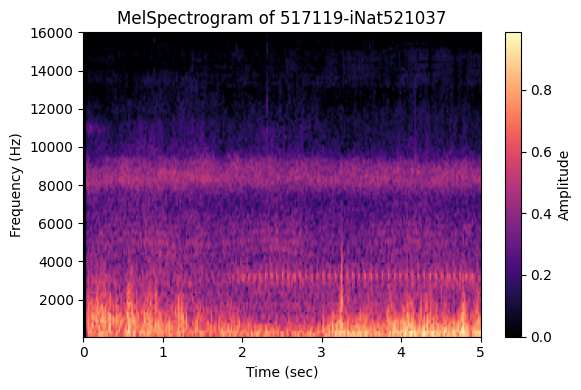

In [28]:

utils_lib.plot_melspectrogram(all_bird_data, "517119-iNat521037")
utils_lib.play_audio("517119/iNat521037.ogg", config.train_datadir)

In [29]:
all_bird_data["517119-iNat521037"]

array([[0.        , 0.        , 0.43539834, ..., 0.8276861 , 0.83280027,
        0.84398335],
       [0.        , 0.        , 0.44407585, ..., 0.84024096, 0.8426354 ,
        0.8623429 ],
       [0.        , 0.        , 0.4577383 , ..., 0.8600083 , 0.85812044,
        0.89124936],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [30]:
# CSAチェック
# 最後にスペイン語が含まれていないlabel
# 1564122, 50186/CSA28885.ogg, 523060
# 52884/CSA14875.ogg
# 548639
# 714022
# 868458



# スペイン語最初に含まれる 4secくらい
# 50186/CSA28885.ogg
# 52884/CSA14875.ogg



# 話してる人
# Eliana Barona- Cortés
# Alexandra Butrago-Cardona
# Fabio A. Sarria-S

# 人の声だけの箇所
# 24292/CSA34649.ogg 2min48移行
# 24292/CSA34651.ogg 1min34移行
# 476537/CSA35459.ogg 2min14移行
# 476537/CSA35461.ogg 4min19移行

In [31]:
# 棒グラフ

working_df_augmented["primary_label"].value_counts()

primary_label
grekis     987
compau     808
trokin     787
roahaw     708
banana     610
          ... 
66016        2
476537       2
528041       2
41778        2
1139490      2
Name: count, Length: 206, dtype: int64

In [32]:
humanvoice_df = pd.read_csv("../data/processed/human_voice/human_voice_0425.csv")
df = working_df[working_df["filename"].isin(humanvoice_df["filename"])]
df = df[df["collection"] != "CSA"]
# 秒数が長いものには人の声が入っている可能性があるので対象とする
df = df[df["duration_sec"] > 7]

# 人の声がない範囲を取得
valid_range_df = extract_valid_ranges(df)
df = valid_range_df.copy()
df = df[(df["valid_end_sec"] - df["valid_start_sec"] <= 5)]
df


NameError: name 'extract_valid_ranges' is not defined

In [ ]:
humanvoice_df = pd.read_csv("../data/processed/human_voice/human_voice_0425.csv")
df = working_df[working_df["filename"].isin(humanvoice_df["filename"])]
df = df[df["collection"] != "CSA"]
# 秒数が長いものには人の声が入っている可能性があるので対象とする
df = df[df["duration_sec"] > 7]

# 人の声がない範囲を取得
valid_range_df = extract_valid_ranges(df)
df = valid_range_df.copy()
df = df[(df["valid_end_sec"] - df["valid_start_sec"] >= 3) & (df["valid_end_sec"] - df["valid_start_sec"] <= 5)]
print(len(df))
utils_lib.plot_and_play_audio("tropar/iNat1231453.ogg", config.train_datadir)


# 7sでフィルター．除去した後の音声の長さが3s以上5s以下のものを評価．26分かかった．全124件
# 書いてない音源は全durationが使えるという意味

# 21211/XC882654.ogg 3.7s以降
#  22976/iNat1192434.ogg 6s以降
# 517119/iNat1282698.ogg 人の声．保留
#  67252/iNat1257838.ogg 全く同じ音源あり．消す
# amekes/iNat863228.ogg 人の声．4s以降
# amekes/iNat863229.ogg 人の声．保留
# banana/iNat483177.ogg 人の声．保留
# bkmtou1/iNat1073839.ogg 人の声．保留．1.5ｓ付近にノイズあり
# bkmtou1/iNat959239.ogg 4s以降
# blkvul/XC324818.ogg 人の声．保留
# cargra1/iNat969137.ogg 全部人の声．消す Valentina
# chbant1/iNat922630.ogg 音がかすか．人の声．保留
# colcha1/iNat583631.ogg 全く同じ音源あり．消す 
# compau/iNat346502.ogg 人の声．音楽．保留
# crcwoo1/XC9296.ogg 2.5s以前．
# greibi1/iNat624338.ogg 人の声．保留
# grekis/iNat388305.ogg 8s以降
#  grekis/iNat979187.ogg 9sから12ｓ
#  grepot1/XC416484.ogg 4s以前
# rufmot1/XC403364.ogg ノイズがすごい
# trokin/iNat1240220.ogg ゴソゴソ．保留


# 7sでフィルター．除去した後の音声の長さが3s以下のものを評価．全72件. 20分かかった
# 書いてない音源は全durationが使えるという意味

# 除去すべき場所を書いていく．
#  21211/XC882650.ogg 9s以降
# 65448/iNat273090.ogg 9s以前
# amekes/iNat522505.ogg 人の歌い声．消していい．
# banana/XC437586.ogg 4sから6.5s
#  banana/XC524992.ogg 10以降
# blchaw1/iNat629789.ogg 15s以前
# grekis/iNat972136.ogg 人の声あり．消していい
# grekis/iNat998004.ogg 2s以前
#  laufal1/iNat19124.ogg 12s以降
# laufal1/iNat428603.ogg 人の声あり．保留
#  laufal1/iNat469782.ogg 人の声あり．保留
# pirfly1/XC309684.ogg 3sから9s

# rosspo1/iNat307857.ogg  全部人の声．消す
# saffin/iNat307815.ogg 全部人の声．消す．author:  Abraham CA
# trokin/XC879492.ogg かなり人の声あり．保留
# trokin/iNat537466.ogg trokin/XC879492.ogg と同じ音声．消す
#  tropar/iNat1231453.ogg 2sから4s
#  watjac1/XC43803.ogg 人の声．保留
#  wbwwre1/iNat1224010.ogg 人の声．保留
#  wbwwre1/iNat1224011.ogg wbwwre1/iNat1224010.oggと同じ．消す．


# 除去ミス
# 555142/iNat761666.ogg OK
# 65448/iNat273090.ogg ほぼ人の声．9s以降OK
# 65448/iNat313963.ogg OK
# 65962/iNat1109807.ogg OK
# 65962/iNat382337.ogg OK
# 67252/XC952184.ogg  OK
# 67252/iNat1257838.ogg 